In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
from data import fMRIData, fMRIDataEval, LUNA, LUNAEval
from operators import MRI, Operator, CT
from torch import nn
from torch.utils.data import DataLoader
from networks import ResNet, ConvNet, ConvenientModel
import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from utils import Norm, mkdir
import json

In [2]:
# Saves
BASE_PATH = '/store/CCIMI/sl767/Experiments/'

In [3]:
# EXPERIMENT = 'MRI_fMRIData_Sobolev_-1_Exp_3_PS_15'
# EXPERIMENT = 'CT_HIGH_NOISE_LUNA_Sobolev_0'
# EXPERIMENT = 'CT_fMRI_Sobolev_0'
EXPERIMENT = 'MRI_LUNA_Sobolev_0'
# EXPERIMENT = 'TV_MRI_fMRI'
# EXPERIMENT = 'TV_CT_LUNA_HIGH_NOISE'
# EXPERIMENT = 'FBP'
# Data Setup
# DATASET = 'fMRI'
MODALITY= 'MRI'
NOISE_LEVEL = 1e-3
N_ANGLES = 60
# INITIAL_MINIMIZATION = False
DATASET = 'LUNA'
# MODALITY= 'CT'
# NOISE_LEVEL = 2e-3
# N_ANGLES = 100
INITIAL_MINIMIZATION = False

# Network training
LEARNING_RATE = 1e-4
DECAY_FACTOR = .7
DECAY_EVERY_NSTEPS = 5000
APPLY_RESCALING = False
BATCH_SIZE = 16
TRAINING_STEPS = 15000
# Regulariser architecture
CHANNELS = [1, 64, 128, 128]
DOWNSAMPLING = [False, True, True]
SOBOLEV = 0
PIXEL_SIZE = 1
# regularisation parameter for gradient penalty
MU = 1
# scales gradient norm with average image norm. Normalizes expected distributional distance to 1.
N_STEPS = 200
STEP_SIZE = .3
THRESHOLDING = False
# tracking
N_IMAGES_LOGGING = 1
TRACKING_FREQ = 500

# Norm scalings - a value of None will auto-set this parameter
# Average noise norms (L2, no rescaling: 17)
AVERAGE_NOISE_NORM = None
AVERAGE_NOISE_DUAL = None
AVERAGE_IMAGE_NORM = None
AVERAGE_DUAL_NORM = None

# AVERAGE_NOISE_NORM = 1
# AVERAGE_NOISE_DUAL = 1
# AVERAGE_IMAGE_NORM = 1 
# AVERAGE_DUAL_NORM = 1

# AVERAGE_NOISE_NORM = .5/17
# AVERAGE_NOISE_DUAL = 1000/17
# AVERAGE_IMAGE_NORM = 1 
# AVERAGE_DUAL_NORM = 1

parameters = {'DATASET': DATASET,
              'MODALITY': MODALITY,
              'NOISE_LEVEL': NOISE_LEVEL, 
              'N_ANGLES': N_ANGLES,
              'INITIAL_MINIMIZATION': INITIAL_MINIMIZATION,
              'LEARNING_RATE': LEARNING_RATE,
              'APPLY_RESCALING': APPLY_RESCALING,
              'DECAY_FACTOR': DECAY_FACTOR,
              'DECAY_EVERY_NSTEPS' : DECAY_EVERY_NSTEPS,
              'BATCH_SIZE': BATCH_SIZE, 
              'TRAINING_STEPS': TRAINING_STEPS, 
              'CHANNELS': CHANNELS,
              'DOWNSAMPLING': DOWNSAMPLING,
              'SOBOLEV': SOBOLEV,
              'PIXEL_SIZE': PIXEL_SIZE,
              'MU': MU,
              'N_STEPS': N_STEPS,
              'STEP_SIZE': STEP_SIZE,
              'THRESHOLDING': THRESHOLDING, 
              'N_IMAGES_LOGGING': N_IMAGES_LOGGING,
              'TRACKING_FREQ': TRACKING_FREQ
             }

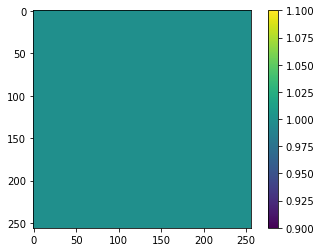

In [4]:
norm = Norm(s = SOBOLEV, c = 1/PIXEL_SIZE)
dual = norm.dual
plt.imshow(dual.mask[0,0,...,0])
plt.colorbar()

Sampling pattern loaded
Number of training samples found 76138
Number of training samples found 14515


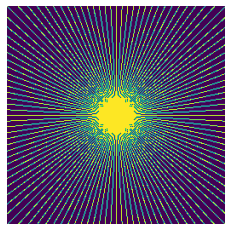

MRI Operator
Resolution 256
Subsampling level: 0.24310302734375

In [5]:
if MODALITY == 'MRI':
    operator = MRI(n_directions=N_ANGLES)
elif MODALITY == 'CT':
    operator = CT(n_angles=N_ANGLES)
if DATASET == 'fMRI':
    data = DataLoader(fMRIData(), batch_size=BATCH_SIZE, num_workers=4)
    val_data = DataLoader(fMRIDataEval(), batch_size=BATCH_SIZE)
elif DATASET == 'LUNA':
    data = DataLoader(LUNA(), batch_size=BATCH_SIZE, num_workers=4)
    val_data = DataLoader(LUNAEval(), batch_size=BATCH_SIZE)
operator

In [6]:
def get_training_data(gt):
    y = operator.add_noise(operator.forward_torch(gt), NOISE_LEVEL)
    x_0 = operator.inverse_torch(y)
    # potentially add a solution of variational problem at this point
    if INITIAL_MINIMIZATION:
        x_0 = solve_variational_problem(x_0, y, 10, .1, 0, tracking=None)
    return x_0, y

In [7]:
def l2(x):
    return torch.mean(torch.sqrt(torch.sum(x ** 2, dim=(1,2,3))))

In [8]:
def get_optimal_lambda():
    gt = next(iter(data)).cuda()
    _, y = get_training_data(gt)
    norm_data = torch.mean(dual(operator.adjoint_torch(operator.forward_torch(gt) - y)))
    return norm_data.cpu().item()

In [9]:
val_gt = next(iter(val_data)).cuda()
val_fbp, val_y = get_training_data(val_gt)

# Find average image norms
if AVERAGE_NOISE_NORM is None:
    AVERAGE_NOISE_NORM = torch.mean(norm(val_gt - val_fbp)).cpu().item()
if AVERAGE_NOISE_DUAL is None:
    AVERAGE_NOISE_DUAL = torch.mean(dual(val_gt - val_fbp)).cpu().item()
if AVERAGE_IMAGE_NORM is None:
    AVERAGE_IMAGE_NORM = torch.mean(norm(val_gt)).cpu().item()
if AVERAGE_DUAL_NORM is None:
    AVERAGE_DUAL_NORM = torch.mean(dual(val_gt)).cpu().item()
parameters['AVERAGE_NOISE_NORM'] = AVERAGE_NOISE_NORM
print('AVERAGE_NOISE_NORM', AVERAGE_NOISE_NORM)
parameters['AVERAGE_NOISE_DUAL'] = AVERAGE_NOISE_DUAL
print('AVERAGE_NOISE_DUAL', AVERAGE_NOISE_DUAL)
parameters['AVERAGE_IMAGE_NORM'] = AVERAGE_IMAGE_NORM
print('AVERAGE_IMAGE_NORM', AVERAGE_IMAGE_NORM)
parameters['AVERAGE_DUAL_NORM'] = AVERAGE_DUAL_NORM
print('AVERAGE_DUAL_NORM', AVERAGE_DUAL_NORM)

# Find optimal Lambda
### Scale optimal lambda by 1/2
if 'FBP' in EXPERIMENT:
    LAMBDA = 0
elif SOBOLEV == -1 and MODALITY=='MRI':
    LAMBDA = get_optimal_lambda()/3
else:
    LAMBDA = get_optimal_lambda()
parameters['LAMBDA'] = LAMBDA
print('LAMBDA', LAMBDA)

AVERAGE_NOISE_NORM 18.918380737304688
AVERAGE_NOISE_DUAL 18.918380737304688
AVERAGE_IMAGE_NORM 123.48504638671875
AVERAGE_DUAL_NORM 123.48504638671875
LAMBDA 8.736452102661133


In [10]:
OVERWRITE = True
mkdir(BASE_PATH + EXPERIMENT)
if os.path.exists(BASE_PATH + EXPERIMENT + '/param.json') and not OVERWRITE:
    print('Parameters found. Not overwriting.')
else:
    if not os.path.exists(BASE_PATH + EXPERIMENT + '/param.json'):
        print('Parameters not found. Creating them')
    else:
        print('Parameters found. OVERWRITING!')
    with open(BASE_PATH + EXPERIMENT + '/param.json',"w") as f:
        json.dump(parameters, f)      

Created directory /store/CCIMI/sl767/Experiments/MRI_LUNA_Sobolev_0
Parameters not found. Creating them


In [11]:
tracker = SummaryWriter(BASE_PATH+f'{EXPERIMENT}/Logs/')
regulariser = ResNet(channels=CHANNELS, downsamples=DOWNSAMPLING, base_path=BASE_PATH, exp_name=EXPERIMENT).cuda()
optimizer = optim.Adam(regulariser.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=DECAY_FACTOR)

KeyboardInterrupt: 

In [ ]:
def solve_variational_problem(x_0, y, n_steps, step_size, lam, tracking=None, x_gt=None, global_step=None):
    '''
    Solves the variational problem starting at x_0, with data term y, n_steps 
    descent steps and regularisation paremeter mu.
    param tracking: Supports values None (no tracking), Variational (writes full tracking history into seperate dir) 
    and 'BestOnly' (writes best value over trajectory to training logger)
    '''
    if tracking == 'Variational':
        p = BASE_PATH+f'{EXPERIMENT}/Logs/Step_{global_step}/Lambda_{lam}/'
        print('Writing variational minimization to directory', p)
        local_writer = SummaryWriter(p)
    def add_scalar(name, value, iteration):
        if tracking == 'Variational':
            local_writer.add_scalar('Variational/'+name, value, iteration)
    def add_image(name, value, iteration):
        if tracking == 'Variational':
            value = torch.clamp(value, 0, 1)
            if value.shape[0] < N_IMAGES_LOGGING:
                v = value.cpu().numpy()
            else:
                v = (value[:N_IMAGES_LOGGING]).cpu().numpy()
            local_writer.add_images('Variational/'+name, v, iteration)
            
    best_per = -1
    best_attained_at = -1
    best_recon = None
    x = x_0.detach()
    add_image('Ground Truth', x_gt, 0)
    for k in range(n_steps):
        data_term = operator.forward_torch(x) - y
        add_scalar('Data_Term', l2(data_term).detach().cpu().numpy(), k)
        data_grad = operator.adjoint_torch(data_term)
        add_scalar('L2_Data_Gradient', l2(data_grad).detach().cpu().numpy(), k)
        add_scalar('Dual_Norm_Data_Gradient', torch.mean(dual(data_grad)).detach().cpu().numpy(), k)
        if tracking  == 'Variational':
            quality = (l2(x_gt-x)).mean().detach().cpu().numpy()
            add_scalar('Quality', quality, k)
            add_image('Reconstruction', x, k)
        if not lam == 0:
            reg_grad = regulariser.gradient(x)
            add_scalar('L2_Regulariser_Gradient', l2(reg_grad).detach().cpu().numpy(), k)
            add_scalar('Dual_Norm_Regulariser_Gradient', torch.mean(dual(reg_grad)).detach().cpu().numpy(), k)
            x = x - step_size * (data_grad + lam*reg_grad)
        else:
            x = x - step_size * data_grad
        if THRESHOLDING:
            x = torch.clamp(x, 0, 1)
        if tracking == 'BestOnly':
            quality = (l2(x_gt-x)).mean().detach().cpu().numpy()
            if quality < best_per or best_per == -1:
                best_attained_at = k
                best_per = quality
                best_recon = torch.clamp(x, 0, 1).detach().cpu().numpy()[0,...]
    if tracking == 'BestOnly':
        plt.figure(figsize=(10,10))
        plt.subplot(131)
        plt.imshow(best_recon[0,...])
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(x_gt.cpu()[0,0,...])
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(x_0.cpu()[0,0,...])
        plt.axis('off')
        plt.show()
        tracker.add_scalar('Network_Training/Reconstruction_Quality', best_per, global_step)
        tracker.add_scalar('Network_Training/Best_Attained_At', best_attained_at, global_step)
        tracker.add_image('Network_Training/Reconstruction', best_recon, global_step)
        tracker.add_image('Network_Training/Ground Truth', torch.clamp(x_gt[0,...], 0, 1).cpu().numpy(), global_step)
        tracker.add_image('Network_Training/FBP', torch.clamp(x_0[0,...], 0, 1).cpu().numpy(), global_step)
        
    return x

In [ ]:
def gradient_penalty(gt, fbp, sobolev=0, tracking=False, global_step=None):
    batch_size = gt.size()[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1).cuda()
    alpha = alpha.expand_as(gt)
    interpolated = Variable(alpha * gt + (1 - alpha) * fbp, requires_grad=True)

    # Calculate probability of interpolated examples
    prob_interpolated = torch.sum(regulariser(interpolated))

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           create_graph=True, retain_graph=True)[0]

    gradients_norm = dual(gradients)
    assert len(gradients_norm.shape) == 1 and gradients_norm.shape[0] == BATCH_SIZE
    penalty = ((torch.nn.ReLU()(gradients_norm - 1)) ** 2).mean()
    if tracking:
        tracker.add_scalar('Network_Training/Gradient_Norm', gradients_norm.mean().detach().cpu().numpy(), global_step)
        tracker.add_scalar('Network_Training/Gradient_Penalty', penalty.detach().cpu().numpy(), global_step)
        
    # Return gradient penalty
    return penalty

In [ ]:
global_step = regulariser.load()
val_gt = next(iter(val_data)).cuda()
val_fbp, val_y = get_training_data(val_gt)

while True:
    for i, gt in enumerate(data):
        if global_step >= TRAINING_STEPS:
            regulariser.save(global_step)
            break
        gt = gt.cuda()
        # get training data
        fbp, y = get_training_data(gt)
        # compute the training loss
        loss = (regulariser(gt) - regulariser(fbp))/AVERAGE_NOISE_NORM
        r = gradient_penalty(gt, fbp, tracking=True, global_step=global_step)
        overall_loss = (loss + MU*r).mean()
        tracker.add_scalar('Network_Training/Distributional_Distance', loss.mean().detach().cpu().numpy(), global_step)
        tracker.add_scalar('Network_Training/Training_Loss', overall_loss.detach().cpu().numpy(), global_step)
        tracker.add_scalar('Network_Training/Learning_Rate', optimizer.param_groups[0]['lr'], global_step)
        # update network parameters
        overall_loss.backward()
        optimizer.step()
        regulariser.zero_grad()

        # solve the variational problem
        if i%TRACKING_FREQ == 0:
            solve_variational_problem(val_fbp, val_y, n_steps=N_STEPS, step_size=STEP_SIZE, lam=LAMBDA, x_gt=val_gt, 
                                      global_step=global_step, tracking='BestOnly')
        if (i%DECAY_EVERY_NSTEPS) == DECAY_EVERY_NSTEPS-1:
            lr_scheduler.step()
            print('Decay step taken')
        global_step += 1
    if global_step >= TRAINING_STEPS:
        break

gt = next(iter(data)).cuda()
fbp, y = get_training_data(gt)
for l in [LAMBDA/3, LAMBDA, LAMBDA*3]:
    solve_variational_problem(val_fbp, val_y, n_steps=N_STEPS, step_size=STEP_SIZE, lam=l, x_gt=val_gt, 
              global_step=global_step, tracking='Variational')
    

In [ ]:
val_gt = next(iter(val_data)).cuda()
val_fbp, val_y = get_training_data(val_gt)
for l in [LAMBDA/3, LAMBDA, LAMBDA*3]:
    solve_variational_problem(val_fbp, val_y, n_steps=N_STEPS, step_size=STEP_SIZE, lam=l, x_gt=val_gt, 
              global_step=global_step, tracking='Variational')